# Петър и вълкът: Реалистична среда

В нашата ситуация Петър можеше да се движи почти без да се уморява или огладнява. В по-реалистичен свят той трябва да сяда и да си почива от време на време, както и да се храни. Нека направим нашия свят по-реалистичен, като приложим следните правила:

1. При придвижване от едно място на друго, Петър губи **енергия** и натрупва **умора**.
2. Петър може да възстанови енергията си, като яде ябълки.
3. Петър може да се освободи от умората, като си почива под дърво или на тревата (т.е. като се придвижи до поле с дърво или трева - зелено поле).
4. Петър трябва да намери и убие вълка.
5. За да убие вълка, Петър трябва да има определени нива на енергия и умора, в противен случай губи битката.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

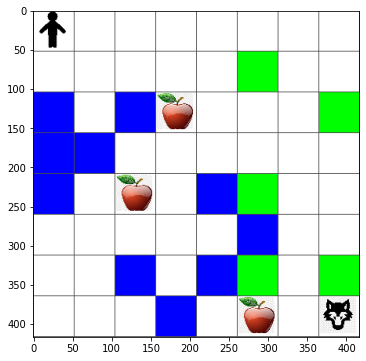

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## Определяне на състояние

В новите правила на играта трябва да следим енергията и умората при всяко състояние на дъската. Затова ще създадем обект `state`, който ще съдържа цялата необходима информация за текущото състояние на проблема, включително състоянието на дъската, текущите нива на енергия и умора, както и дали можем да победим вълка, когато сме в крайно състояние:


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

Нека опитаме да решим проблема, използвайки случаен ход, и да видим дали ще успеем:


In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## Функция за възнаграждение

Функцията за възнаграждение е ключов компонент в системите за обучение с подсилване. Тя определя как агентът оценява стойността на своите действия в дадена среда.

### Основни принципи

- **Яснота**: Уверете се, че функцията за възнаграждение е лесна за разбиране и не съдържа двусмислици.  
- **Съответствие**: Тя трябва да отразява целите на задачата, която се опитвате да оптимизирате.  
- **Избягване на нежелани поведения**: Лошо проектирана функция за възнаграждение може да доведе до неочаквани или нежелани резултати.  

### Пример за функция за възнаграждение

```python
def reward_function(state, action):
    if state == "goal":
        return 10  # Възнаграждение за достигане на целта
    elif action == "invalid":
        return -5  # Наказание за невалидно действие
    else:
        return 0  # Няма възнаграждение за неутрални действия
```

### Често срещани грешки

- **Прекомерно възнаграждение**: Ако възнаграждението е твърде високо, агентът може да се фокусира само върху краткосрочни цели.  
- **Прекомерно наказание**: Твърде големите наказания могат да обезкуражат агента и да забавят обучението.  
- **Пропускане на важни сценарии**: Уверете се, че функцията за възнаграждение обхваща всички възможни състояния и действия.  

### Съвети за проектиране

- Тествайте функцията за възнаграждение в различни сценарии, за да гарантирате, че тя води до желаното поведение.  
- Използвайте симулации, за да наблюдавате как агентът реагира на различни възнаграждения и наказания.  
- Постепенно настройвайте стойностите на възнагражденията и наказанията, за да постигнете оптимален баланс.  

### Заключение

Добре проектираната функция за възнаграждение е от съществено значение за успеха на системите за обучение с подсилване. Отделете време, за да я разработите внимателно и да я тествате в различни условия.


In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## Алгоритъмът Q-Learning

Самият алгоритъм за учене остава почти непроменен, просто използваме `state` вместо само позиция на дъската.


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

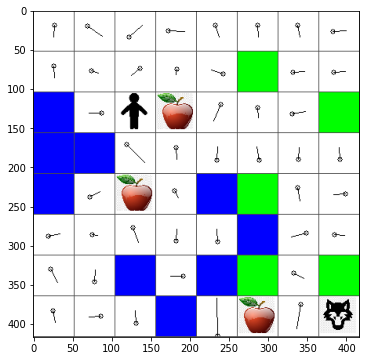

In [11]:
m.plot(Q)

## Резултати

Нека видим дали успяхме да обучим Петър да се бори с вълка!


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


Сега виждаме много по-малко случаи на удавяне, но Питър все още не винаги успява да убие вълка. Опитайте да експериментирате и вижте дали можете да подобрите този резултат, като играете с хиперпараметрите.


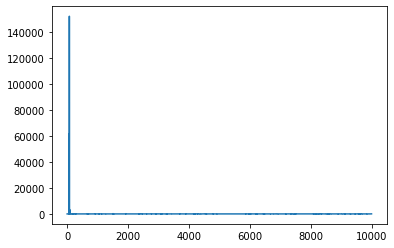

In [13]:
plt.plot(lpath)


---

**Отказ от отговорност**:  
Този документ е преведен с помощта на AI услуга за превод [Co-op Translator](https://github.com/Azure/co-op-translator). Въпреки че се стремим към точност, моля, имайте предвид, че автоматичните преводи може да съдържат грешки или неточности. Оригиналният документ на неговия изходен език трябва да се счита за авторитетен източник. За критична информация се препоръчва професионален превод от човек. Ние не носим отговорност за каквито и да е недоразумения или погрешни интерпретации, произтичащи от използването на този превод.
